In [1]:
!cp -a /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/ ./

In [2]:
!rm genres_original/reggae/reggae.00086.wav
!rm genres_original/jazz/jazz.00054.wav

In [3]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import keras_cv
from matplotlib import pyplot as plt
from IPython.display import Audio


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


In [4]:
tf.config.list_physical_devices()

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [6]:
BATCH_SIZE = 8
EPOCHS = 2
SR = 22050
LR = 1e-5
AUDIO_TIME_LENGTH_SECONDS = 30.0
TEST_SIZE_RATE = 0.01

NFFT = 512
WINDOW = 512
STRIDE = 256
SPECTRO_MELS = 128

RAW_AUDIO_DATASET_PATH = 'genres_original/'
DATASETS_SEED = 5645436

CLASS_LABELS = [
    'blues',
    'classical',
    'country',
    'disco',
    'hip-hop',
    'jazz',
    'metal',
    'pop',
    'reggae',
    'rock',
]

In [7]:
sample_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=RAW_AUDIO_DATASET_PATH,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=BATCH_SIZE,
    sampling_rate=SR,
    output_sequence_length=(AUDIO_TIME_LENGTH_SECONDS * SR),
    ragged=False,
    shuffle=True,
    seed=DATASETS_SEED,
    validation_split=0.05,
    subset='validation',
    follow_links=False
)

Found 998 files belonging to 10 classes.
Using 49 files for validation.


In [8]:
def raw_wav2spectrogram(x, y):
    x_sqzd = tf.squeeze(x, axis=-1)
    x_spectro = tfio.audio.spectrogram(
        input=x_sqzd,
        nfft=NFFT,
        window=WINDOW,
        stride=STRIDE,
        name=None
    )
    x_mel_spectro = tfio.audio.melscale(x_spectro, rate=SR, mels=SPECTRO_MELS, fmin=0, fmax=8000)
    #x_dbscale_mel_spectro = tfio.audio.dbscale(x_mel_spectro, top_db=80)
    #return x_dbscale_mel_spectro, y
    x_log_mel_spectro = tf.math.log(x_mel_spectro)
    #x_normalized = tf.image.per_image_standardization(x_log_mel_spectro)
    x = tf.where(tf.math.is_nan(x_log_mel_spectro), tf.constant(10.0, dtype=tf.float32), x_log_mel_spectro)
    return x, y

x.shape: (8, 661500, 1) -> x.dtype: float32
y.shape: (8,) -> y.dtype: int32


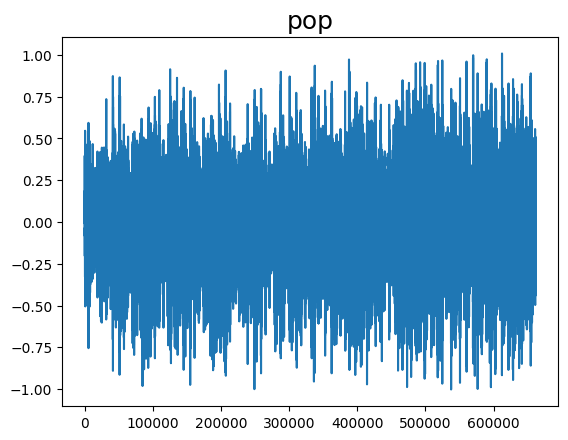

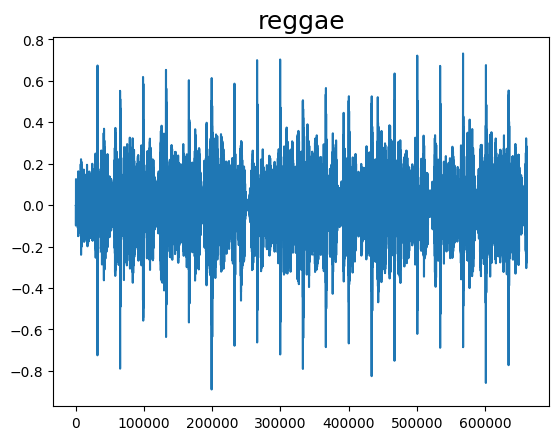

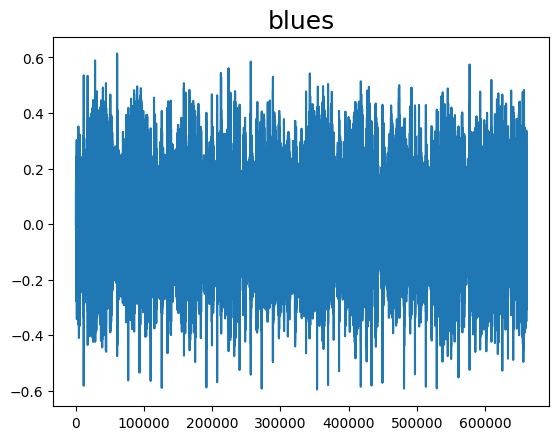

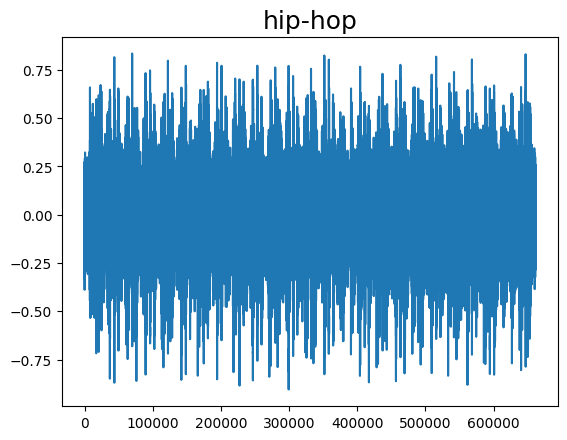

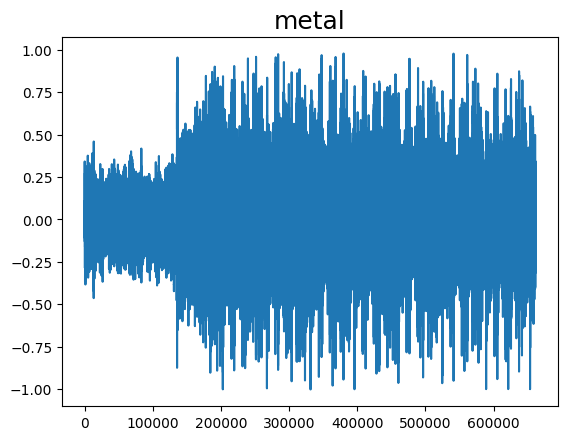

In [9]:
for x, y in sample_dataset.as_numpy_iterator():
    print(f'x.shape: {x.shape} -> x.dtype: {x.dtype}')
    print(f'y.shape: {y.shape} -> y.dtype: {y.dtype}')
    plt.Figure(figsize=(8, 5), dpi=150)
    for i in range(min(x.shape[0], 5)):
        plt.plot(x[i, :, 0])
        plt.title(CLASS_LABELS[y[i]], fontsize=18)
        plt.show()
        plt.close()
        display(Audio(x[i, :, 0], rate=SR))
        print('=' * 100)
    break

In [10]:
sample_dataset = sample_dataset.map(raw_wav2spectrogram)

x.shape: (8, 2584, 128) -> x.dtype: float32
y.shape: (8,) -> y.dtype: int32


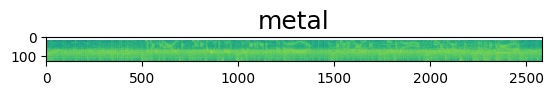

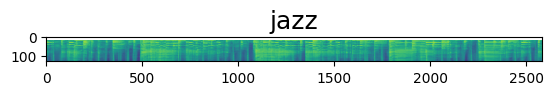

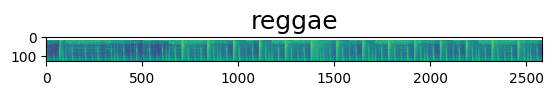

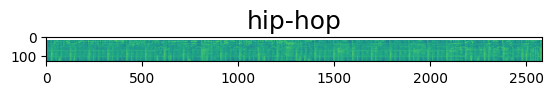

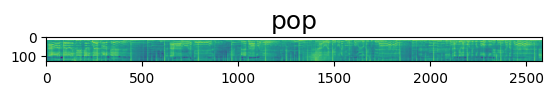

In [11]:
for x, y in sample_dataset.as_numpy_iterator():
    print(f'x.shape: {x.shape} -> x.dtype: {x.dtype}')
    print(f'y.shape: {y.shape} -> y.dtype: {y.dtype}')
    plt.Figure(figsize=(8, 5), dpi=150)
    for i in range(min(x.shape[0], 5)):
        plt.imshow(x[i].T)
        plt.title(CLASS_LABELS[y[i]], fontsize=18)
        plt.show()
        plt.close()
        print('=' * 100)
    break

In [12]:
del sample_dataset

In [13]:
training_dataset, testing_dataset = tf.keras.utils.audio_dataset_from_directory(
    directory=RAW_AUDIO_DATASET_PATH,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=BATCH_SIZE,
    sampling_rate=SR,
    output_sequence_length=(AUDIO_TIME_LENGTH_SECONDS * SR),
    ragged=False,
    shuffle=True,
    seed=DATASETS_SEED,
    validation_split=TEST_SIZE_RATE,
    subset='both',
    follow_links=False
)

Found 998 files belonging to 10 classes.
Using 989 files for training.
Using 9 files for validation.


In [14]:
training_dataset = training_dataset.unbatch()
training_dataset = training_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
training_dataset = training_dataset.batch(BATCH_SIZE)

In [15]:
training_dataset = training_dataset.map(raw_wav2spectrogram)
testing_dataset = testing_dataset.map(raw_wav2spectrogram)
testing_dataset = testing_dataset.cache().prefetch(tf.data.AUTOTUNE)

In [16]:
PROBA = 1./3.
permuter = tf.keras.layers.Permute([1, 3, 2])
augmenter = keras_cv.layers.Augmenter(
    [
        #keras_cv.layers.RandomFlip(),
        keras_cv.layers.ChannelShuffle(groups=8),
        keras_cv.layers.RandomCutout(height_factor=PROBA, width_factor=0.10, fill_mode="gaussian_noise", fill_value=0.0),
        keras_cv.layers.RandomGaussianBlur(factor=PROBA, kernel_size=(2, 2)),
#         keras_cv.layers.GridMask(
#             ratio_factor=(0, 0.05),
#             rotation_factor=0.15,
#             fill_mode="gaussian_noise",
#             fill_value=0.0,
#         ),
    ],
)

def augment_spectrograms(x, y):
    x = tf.reshape(x, (-1, 323, 8, SPECTRO_MELS))
    x = permuter(x)
    x = augmenter(x)
    x = permuter(x)
    x = tf.reshape(x, (-1, 2584, SPECTRO_MELS))
    x = tf.where(tf.math.is_nan(x), tf.constant(10.0, dtype=x.dtype), x)
    return x, y

training_dataset = training_dataset.map(augment_spectrograms)
training_dataset = training_dataset.repeat(10).prefetch(tf.data.AUTOTUNE)

x.shape: (8, 2584, 128) -> x.dtype: float16
y.shape: (8,) -> y.dtype: int32


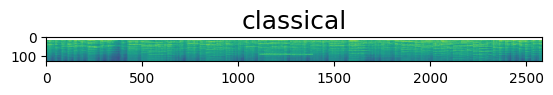

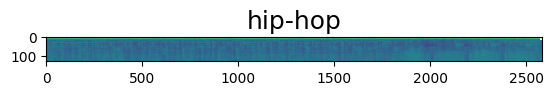

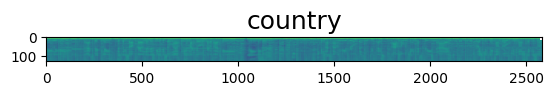

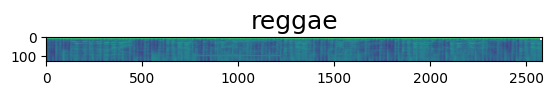

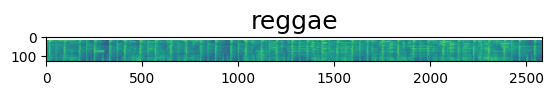

In [17]:
for x, y in training_dataset.as_numpy_iterator():
    print(f'x.shape: {x.shape} -> x.dtype: {x.dtype}')
    print(f'y.shape: {y.shape} -> y.dtype: {y.dtype}')
    plt.Figure(figsize=(16, 9), dpi=300)
    for i in range(min(x.shape[0], 5)):
        plt.imshow(x[i].T)
        plt.title(CLASS_LABELS[y[i]], fontsize=18)
        plt.show()
        plt.close()
        print('=' * 100)
    break

In [18]:
def conv2d_block(
    h, 
    filters=(4, 4, 4), 
    kernel_size=(3, 3, 3), 
    strides=(1, 1, 1), 
    padding='same', 
    activation=None, 
    data_format='channels_last',
    pool_size=(2, 2),
    pool_strides=None,
    pool_padding='same',
):
    assert len(filters) == len(kernel_size)
    for i in range(len(filters)):
        h = tf.keras.layers.Conv2D(
            filters=filters[i],
            kernel_size=kernel_size[i],
            strides=strides[i],
            padding=padding,
            data_format=data_format,
            activation=activation,
        )(h)
    if pool_size is not None:
        h = tf.keras.layers.MaxPooling2D(
            pool_size=pool_size,
            strides=pool_strides,
            padding=pool_padding,
            data_format=data_format,
        )(h)
    return h

In [19]:
from tensorflow.keras import backend as K

class SparseAUC(tf.keras.metrics.AUC):
    def __init__(self, name='ROC_AUC', **kwargs):
        super(SparseAUC, self).__init__(name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, dtype=tf.int32), tf.shape(y_pred)[-1]), axis=-2)
        return super(SparseAUC, self).update_state(y_true, y_pred, sample_weight)


def compile_deep_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='Accuracy'),
            SparseAUC(),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Top3_accuracy'),
        ]
    )

In [20]:
def make_deep_model2(input_shape=(2584, 128)):
    model_inputs = tf.keras.Input(shape=input_shape, dtype=tf.float32, ragged=False)
    h = model_inputs
    h = tf.expand_dims(h, axis=-1)
    
    #h = tf.reshape(h, (-1, 323, 8, 128))
    #h = tf.keras.layers.Permute([1, 3, 2])(h)
    

#     h0 = tf.keras.layers.Conv2D(filters=2048, kernel_size=3, strides=3, activation='relu', padding='valid')(h)
#     h0 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=1)(h0)
    
#     h1 = tf.keras.layers.Conv2D(filters=2048, kernel_size=5, strides=3, activation='relu', padding='same')(h)
#     h1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=1)(h1)

#     tf.print(h0.shape)
#     tf.print(h1.shape)
#     h = tf.concat([h0, h1], axis=-1)

    h = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='valid')(h)
    h = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, activation='relu', padding='valid')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=3, strides=3)(h)
    
    h = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, activation='relu', padding='valid')(h)
    h = tf.keras.layers.MaxPooling2D(pool_size=3, strides=3)(h)
    
    h = tf.keras.layers.Flatten()(h)
    h = tf.keras.layers.Dense(256, activation=None)(h)
    h = tf.keras.layers.LayerNormalization()(h)
    h = tf.keras.activations.elu(h)
    h = tf.keras.layers.Dense(len(CLASS_LABELS), activation='softmax')(h)
    
    model_outputs = h
    deep_model = tf.keras.Model(model_inputs, model_outputs)
    return deep_model


deep_model = make_deep_model2()
compile_deep_model(deep_model)
display(deep_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2584, 128)]       0         
                                                                 
 tf.expand_dims (TFOpLambda  (None, 2584, 128, 1)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 2582, 126, 128)    1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 2580, 124, 512)    590336    
                                                                 
 max_pooling2d (MaxPooling2  (None, 860, 41, 512)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 858, 39, 1)        4609  

None

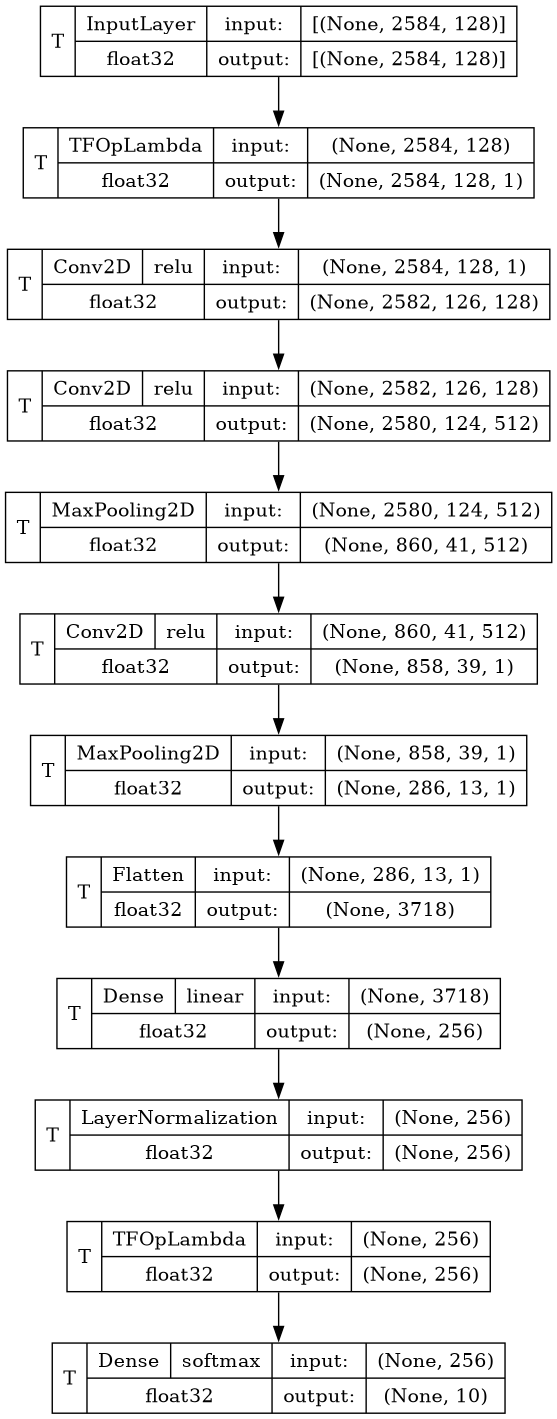

In [21]:
tf.keras.utils.plot_model(
    deep_model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=False,
    dpi=100,
    show_layer_activations=True,
    show_trainable=True
)

In [22]:
training_history = deep_model.fit(
    training_dataset,
    epochs=EPOCHS,
    validation_data=testing_dataset,
)

Epoch 1/2
1240/1240 [==============================] - 1373s 1s/step - loss: nan - Accuracy: 0.1008 - ROC_AUC: 0.4997 - Top3_accuracy: 0.1372 - val_loss: nan - val_Accuracy: 0.1111 - val_ROC_AUC: 0.5000 - val_Top3_accuracy: 0.0000e+00
Epoch 2/2
1240/1240 [==============================] - 1320s 1s/step - loss: nan - Accuracy: 0.0956 - ROC_AUC: 0.5003 - Top3_accuracy: 0.1357 - val_loss: nan - val_Accuracy: 0.1111 - val_ROC_AUC: 0.5000 - val_Top3_accuracy: 0.0000e+00
